# __This is a notebook of a PyTorch Dubai Aerial photo segmentation with Pytorch Unet++ (ResNet101 backbone)!__ 
# Project by __[Nikita Bezukhov](https://github.com/NikitaBezukhov)__!
### The data set is __[Semantic segmentation of aerial imagery from Kaggle](https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery)__.
### Was built in __[Google Colab](https://colab.research.google.com/)__ environment, so make any adjustments needed for it to work on your machine.

####
####
## __1. First lets install, import and define all necessary libraries/classes/functions that we will be using.__

In [ ]:
pip install barbar git+https://github.com/albumentations-team/albumentations segmentation_models_pytorch 

In [ ]:
import os
import segmentation_models_pytorch 
import logging
import torch
import gc
import re
from math import exp
import cv2
import random
import torchvision
from imageio import imread
import torch.nn as nn
from PIL import Image, ImageOps, ImageShow
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.metrics import jaccard_score
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torchvision import transforms, datasets 
from shutil import copyfile, move
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import torch
import pandas as pd
from torchsummary import summary
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import math
from torchvision import models
import torch.utils.model_zoo as model_zoo
from itertools import chain
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'/content/drive/MyDrive/aerialmodel.pt') 
        self.val_loss_min = val_loss

In [ ]:
def square_the_image(image):
  
    desired_size = max(image.size[0], image.size[1])
    old_size = (image.size)  

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    image = image.resize(new_size, Image.ANTIALIAS)

    squared_image = Image.new("RGB", (desired_size, desired_size))
    squared_image.paste(image, ((desired_size-new_size[0])//2,
                      (desired_size-new_size[1])//2))

    return np.array(squared_image)

In [ ]:
color_dict = {0: (0, 0, 0),
              1: (254, 221,  58),
              2: (132,  41, 246),
              3: (110, 193, 228),
              4: (60, 16, 152),
              5: (226, 169, 41),
              6: (155, 155, 155)}


def rgb_to_onehot(rgb_arr, color_dict=color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return torchvision.transforms.ToTensor()(arr)


def onehot_to_rgb(onehot, color_dict=color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [ ]:
class Metric(object):
    """Base class for all metrics.
    From: https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py
    """
    def reset(self):
        pass

    def add(self):
        pass

    def value(self):
        pass

class ConfusionMatrix(Metric):
    """Constructs a confusion matrix for a multi-class classification problems.
    Does not support multi-label, multi-class problems.
    Keyword arguments:
    - num_classes (int): number of classes in the classification problem.
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    Modified from: https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
    """

    def __init__(self, num_classes, normalized=False):
        super().__init__()

        self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        self.normalized = normalized
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.conf.fill(0)

    def add(self, predicted, target):
        """Computes the confusion matrix
        The shape of the confusion matrix is K x K, where K is the number
        of classes.
        Keyword arguments:
        - predicted (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        predicted scores obtained from the model for N examples and K classes,
        or an N-tensor/array of integer values between 0 and K-1.
        - target (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        ground-truth classes for N examples and K classes, or an N-tensor/array
        of integer values between 0 and K-1.
        """
        # If target and/or predicted are tensors, convert them to numpy arrays
        if torch.is_tensor(predicted):
            predicted = predicted.cpu().numpy()
        if torch.is_tensor(target):
            target = target.cpu().numpy()

        assert predicted.shape[0] == target.shape[0], \
            'number of targets and predicted outputs do not match'

        if np.ndim(predicted) != 1:
            assert predicted.shape[1] == self.num_classes, \
                'number of predictions does not match size of confusion matrix'
            predicted = np.argmax(predicted, 1)
        else:
            assert (predicted.max() < self.num_classes) and (predicted.min() >= 0), \
                'predicted values are not between 0 and k-1'

        if np.ndim(target) != 1:
            assert target.shape[1] == self.num_classes, \
                'Onehot target does not match size of confusion matrix'
            assert (target >= 0).all() and (target <= 1).all(), \
                'in one-hot encoding, target values should be 0 or 1'
            assert (target.sum(1) == 1).all(), \
                'multi-label setting is not supported'
            target = np.argmax(target, 1)
        else:
            assert (target.max() < self.num_classes) and (target.min() >= 0), \
                'target values are not between 0 and k-1'

        # hack for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int64), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        self.conf += conf

    def value(self):
        """
        Returns:
            Confustion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf        


class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).
    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:
        IoU = true_positive / (true_positive + false_positive + false_negative).
    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized)

        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.
        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.
        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.
        The mean computation ignores NaN elements of the IoU array.
        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

## __2. Data preparation.__
### Dataset consists of 72 Dubai aerial photos and ground truth masks consisting of 6 classes:
#### 1.Building
#### 2.Land (unpaved area)
#### 3.Road
#### 4.Vegetation 
#### 5.Water 
#### 6.Unlabeled 
#### We will one-hot encode our masks for a loss function backprop and then will be able to reverse one-hot to look at results of our model's work with functions we defined above: "rgb_to_onehot" and "onehot_to_rgb". (All the colors for classes are saved in color_dict of a function.
### Since dataset is so small I decided to hand pick 16 different pics for validation and leave other 56 for training.
### We will unzip it and put image and mask path in lists for our custom dataset.

In [ ]:
!unzip /content/drive/MyDrive/aerial.zip -d /content

In [ ]:
train_photos = '/content/train_photo/'
train_masks = '/content/train_mask/'
val_photos = '/content/val_photo/'
val_masks = '/content/val_mask/'

In [ ]:
print(len(os.listdir(train_photos)))
print(len(os.listdir(train_masks)))
print(len(os.listdir(val_photos)))
print(len(os.listdir(val_masks)))

56
56
16
16


In [ ]:
train_photos_paths = [train_photos + photo for photo in os.listdir(train_photos)]
train_masks_paths = [train_masks + mask for mask in os.listdir(train_masks)]
val_photos_paths = [val_photos + photo for photo in os.listdir(val_photos)]
val_masks_paths = [val_masks + mask for mask in os.listdir(val_masks)]

In [ ]:
train_photos_paths = sorted(train_photos_paths)
train_masks_paths = sorted(train_masks_paths)
val_photos_paths = sorted(val_photos_paths)
val_masks_paths = sorted(val_masks_paths)

In [ ]:
for i,every in enumerate(train_photos_paths):
    print(every,train_masks_paths[i])

In [ ]:
for i,every in enumerate(val_photos_paths):
    print(every,val_masks_paths[i])

##
## __3. Data augmentation.__
### Dataset consists of pictures of different size 500-800 pixels on HxW and are rectangular (but almost square). At the start of the notebook we defined "square_the_image" function that will 0 pad each picture so that it becomes a square.
### Since pictures have a lot of small detailes, to not lose them I decided to resize all of them to 800x800 pixels. 
### We will be using Albumentations image augmentation library to transform scans and corresponding masks in the same way.
### I found next augmentations to make the most sense for this dataset: affine transformations with zoom 0.9-1.1, shift -0.15-0.15 and rotation -180-180 degrees and shear -10-10 degrees. Also I found random grid shuffle to be an appropriate augmentation for this kind of data. (splitting image into 4 equal squares and randomly shuffling them)
### We also incorporate random horizontal flip and normalization. (we will calculate mean and std for normalization later)

In [35]:
image_size = 800

train_transforms = A.Compose([
    A.Resize (image_size, image_size, p=1.0),
    A.RandomGridShuffle(grid=(2, 2), p=0.33),
    A.augmentations.geometric.transforms.Affine(scale=(0.9,1.1), translate_percent={'x':(-0.15,0.15),'y':(-0.15,0.15)}, 
                                                rotate=(-180,180), shear=(-10,10), p=1.0),
    A.HorizontalFlip(p=0.5),
])

normalize_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.3630, 0.3662, 0.3691], std=[0.3343, 0.3351, 0.3461])
])


to_tensor_transforms = transforms.Compose([
    transforms.ToTensor()
])

val_transforms = A.Compose([
    A.Resize (image_size, image_size, p=1.0),
])

### Next we make our custom dataset and specify order of all needed transformations.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.train = train

    def transform(self, image, mask, train):
        if train:
            transformed = train_transforms(image=image, mask=mask)            
            tensor_image = to_tensor_transforms(transformed['image'])
            normalized_img = normalize_transforms(tensor_image)
        else:          
            transformed = val_transforms(image=image, mask=mask)
            tensor_image = to_tensor_transforms(transformed['image'])
            normalized_img = normalize_transforms(tensor_image)
            
        return normalized_img, transformed['mask']

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        squared_image = square_the_image(image)
        squared_mask = square_the_image(mask)
        x, y = self.transform(squared_image, squared_mask, self.train)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [ ]:
train_dataset = MyDataset(train_photos_paths, train_masks_paths, train=True)
val_dataset = MyDataset(val_photos_paths, val_masks_paths, train=False)

### Batch size chosen as 2 because it is all I could fit in 16gb Colab Pro GPU, but we will be using PyTorch gradient accumulation, so effectively we will have batch size of 28-56 images. I trained model on batch size of 28 and then fine-tuned with batch size of 56 to gain last bits of performance. (Random augmentations will prevent us from overfitting)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False,
    pin_memory=False, drop_last=False)

### Mean and std calculation for normalization.

In [ ]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, label in train_loader:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
# pixel count
count = 56 * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

In [ ]:
def Dice_and_iou(inputs, targets, smooth=1e-6):
    
    #comment out if your model contains a sigmoid or equivalent activation layer
    # inputs = F.sigmoid(inputs)       
    
    #flatten label and prediction tensors
    inputs = inputs.reshape(-1)
    targets = targets.reshape(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
    iou = (intersection + smooth)/(inputs.sum() + targets.sum() - intersection + smooth)  
    return dice, iou    

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()  
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)                               
        return (1-dice)/28

## __4. Training.__
### Model we will be using is Unet++ with ResNet101 backbone and ImageNet weights from __[here](https://github.com/qubvel/segmentation_models.pytorch)__!
### We define it with 7 channel output for a mask. (6 dataset classes + 0 padded black borders from data augmentations)
### Model was learning pretty fast so low starting learning rate was chosen to prevent instability. Also because of models fast learning a lot of the times momentum was starting to carry the model away from point of minimum, and since each batch size is big enough and pretty representative of distribution we are trying to learn, I decided to lower momentum to 0.5 for faster and more stable training. ReduceLROnPlateau is also used.
### Training process will be logged to TensorBoard.

In [ ]:
device = 'cuda'

num_classes = 7
         

model = segmentation_models_pytorch.UnetPlusPlus(encoder_name="resnet101",in_channels=3, classes=7,
                                                 aux_params=None, encoder_weights="imagenet").to(device)   

criterion = DiceLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.0001, betas=(0.5,0.999))

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, cooldown=10, verbose=True)

epochs = 999

writer = SummaryWriter(log_dir='/content/drive/MyDrive/aerial_logs/', filename_suffix="aerial")

### Patience of 100 epochs was chosen since each epoch is basically 1-2 parameter updates and so big value for patience is needed.

In [ ]:
early_stopping = EarlyStopping(patience=100, verbose=True)
batch_count = 0

for epoch in range(epochs):
    train_loss = []
    val_loss = []
    all_train_iou = []
    all_val_iou = []
    all_train_dice = []
    all_val_dice = []
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, masks) in enumerate(Bar(train_loader)):
        batch_count += 1
        model.train()
        masks_one_hot = torch.tensor([])
        for every in masks:
            masks_one_hot = torch.cat((masks_one_hot, rgb_to_onehot(every.numpy()).view(1,num_classes, image_size, image_size)))
        inputs, masks_one_hot = inputs.to(device), masks_one_hot.to(device)
        outputs = model(inputs) 
        loss = criterion(F.softmax(outputs,dim=1), masks_one_hot) 
        loss.backward() 
        if batch_count % 28 == 0:
            optimizer.step() 
            optimizer.zero_grad() 
        train_loss.append(28*loss.item())
        train_dice, train_iou = Dice_and_iou(F.softmax(outputs,dim=1).round(), masks_one_hot)
        all_train_iou.append(train_iou) 
        all_train_dice.append(train_dice)
          
    all_train_iou = sum(all_train_iou)/(len(all_train_iou)+1e-6)
    all_train_dice = sum(all_train_dice)/(len(all_train_dice)+1e-6)     
    print(f"Train IoU: {all_train_iou}")
    print(f"Train Dice: {all_train_dice}")
    train_loss_final = sum(train_loss)/(len(train_loss)+1e-6)
    scheduler.step(train_loss_final)
    train_loss_formated = "{:.4f}".format(train_loss_final)

    # Validation loop
    with torch.no_grad():
        for inputs, masks in val_loader:
            model.eval()       
            masks_one_hot = torch.tensor([])
            for every in masks:
                masks_one_hot = torch.cat((masks_one_hot, rgb_to_onehot(every.numpy()).view(1,num_classes, image_size, image_size)))
            inputs, masks_one_hot = inputs.to(device), masks_one_hot.to(device)
            outputs = model(inputs)
            loss = criterion(F.softmax(outputs,dim=1), masks_one_hot) 
            val_loss.append(28*loss.item())
            val_dice, val_iou = Dice_and_iou(F.softmax(outputs,dim=1).round(), masks_one_hot)
            all_val_iou.append(val_iou)
            all_val_dice.append(val_dice)
    
    all_val_iou = sum(all_val_iou)/(len(all_val_iou)+1e-6)
    all_val_dice = sum(all_val_dice)/(len(all_val_dice)+1e-6)
    print(f"Val IoU: {all_val_iou}")   
    print(f"Val dice: {all_val_dice}")    
    val_loss_final = sum(val_loss)/(len(val_loss)+1e-6)
    val_loss_formated = "{:.4f}".format(val_loss_final)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {val_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss_final, epoch+1)
    writer.add_scalar('Loss/val', val_loss_final, epoch+1)
    writer.add_scalar('IoU/train', all_train_iou, epoch+1)
    writer.add_scalar('IoU/val', all_val_iou, epoch+1)
    writer.add_scalar('Dice/train', all_train_dice, epoch+1)
    writer.add_scalar('Dice/val', all_val_dice, epoch+1)
  

    # Early Stopping
    early_stopping(val_loss_final, model)       
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('/content/drive/MyDrive/aerialmodel.pt'))     

##
## __5. Results.__
### Model training for around 250 epocs (2.5 hours) with a batch size of 28 and fine tuned for couple more hours with a batch size of 56. 
### Result metrics are:
#### Train IoU: 0.9059
#### Train Dice: 0.9501
####
#### Val IoU: 0.7506
#### Val Dice: 0.8558
####
#### Training Loss: 0.0534
#### Validation Loss: 0.1467
####
#### Difference between train and val metrics is mostly due to small val dataset, not overfitting.
### Now we will look ar by class IoU and make per pixel classification confusion matrix and classification report.

In [ ]:
iou_metric = IoU(num_classes, normalized=False, ignore_index=None)
iou_metric.reset()
with torch.no_grad():
    for inputs, masks in val_loader:
        model.eval()       
        masks_one_hot = torch.tensor([])
        for every in masks:
            masks_one_hot = torch.cat((masks_one_hot, rgb_to_onehot(every.numpy()).view(1,num_classes, image_size, image_size)))
        inputs, masks_one_hot = inputs.to(device), masks_one_hot.to(device)
        outputs = model(inputs)
        iou_metric.add(torch.softmax(outputs,dim=1), masks_one_hot)


iou, mean_val_iou = iou_metric.value()
print(f"""By class IoU:
Vegetation   {iou[1]}
Land         {iou[2]}
Road         {iou[3]}
Building     {iou[4]}
Water        {iou[5]}
Unlabeled    {iou[6]}""")


By class IoU:
Vegetation   0.694488699441202
Land         0.7508653792523501
Road         0.5462118738509806
Building     0.638781656855028
Water        0.8631276465130994
Unlabeled    0.0


### The smallest IoU is for unlabeled class and as we will see lower it mostly got classified as land and buildings. It probably is some special class of buildings in Dubai or just hard to identify objects, so this result is understandable.
### Second and third lowest IoU is Road and Building classes which are also anderstandably some of the hardest to get accurate since they  are pretty small on theese photos.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Bord.       0.99      0.99      0.99   1330085
      Veget.       0.88      0.77      0.82   1408415
        Land       0.83      0.89      0.86   3921249
        Road       0.74      0.68      0.71    908570
      Build.       0.82      0.75      0.78   1158302
       Water       0.89      0.96      0.93   1429651
    Unlabel.       0.00      0.00      0.00     83728

    accuracy                           0.86  10240000
   macro avg       0.73      0.72      0.73  10240000
weighted avg       0.85      0.86      0.85  10240000



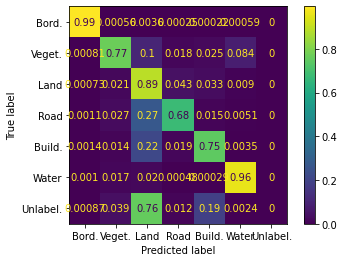

In [ ]:
num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
all_masks_one_hot = torch.tensor([])

with torch.no_grad():
    for i, (inputs, masks) in enumerate(val_loader):
        model.eval()
        inputs = inputs.to(device)
        masks = masks.to(device)
        outputs = model(inputs)
        masks_one_hot = torch.tensor([])
        for every in masks:
            masks_one_hot = torch.cat((masks_one_hot, rgb_to_onehot(every.cpu().numpy()).view(1,num_classes, image_size, image_size)))
        all_masks_one_hot=torch.cat([all_masks_one_hot,masks_one_hot.cpu()])
        # Append batch prediction results
        predlist=torch.cat([predlist,torch.argmax(outputs,dim=1).view(-1).cpu()])
        lbllist=torch.cat([lbllist,torch.argmax(masks_one_hot,dim=1).view(-1).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()

# Confusion matrix, classification report and AUC
conf_mat=confusion_matrix(lbllist, predlist)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
target_names = ['Bord.','Veget.','Land','Road','Build.','Water','Unlabel.',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot()
print(classification_report(lbllist, predlist, target_names=target_names))

### Considering the size of the dataset I think that results that we got are pretty good!
### Next we can plot results of our model's work!

In [36]:
masks = torch.tensor([])
modeled_masks = torch.tensor([])
rgb_modeled_masks = []
with torch.no_grad():
    for inputs, mask in val_loader:
        model.eval()       
        inputs= inputs.to(device)
        outputs = model(inputs)
        masks = torch.cat((masks,mask.permute(0,3,1,2)))
        modeled_masks = torch.cat((modeled_masks,outputs.cpu()))
for every in modeled_masks:
     rgb_modeled_masks.append(onehot_to_rgb(every.permute(1,2,0)))

In [37]:
normalize_transforms = transforms.Compose([
])

In [38]:
unnormalized_pics = torch.tensor([])
with torch.no_grad():
    for inputs, mask in val_loader:
        unnormalized_pics = torch.cat((unnormalized_pics, inputs))

In [ ]:
count = 0
for j in range(16):
    count += 1
    fig = plt.figure(figsize=(20,8))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(unnormalized_pics[j].permute(1,2,0))
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(masks[j].int().permute(1,2,0))
    ax2.grid(False)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(rgb_modeled_masks[j])
    ax3.grid(False)

#     plt.savefig('/content/drive/MyDrive/predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
    plt.show()